In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


CNN(Convolutional Neural Network) - 합성곱 신경망

In [2]:
# MNIST 데이터를 내려받아 학습 데이터 및 테스트 데이터로 분리해서 저장한다.
# MNIST 데이터 28 * 28의 픽셀 데이터이고 각 픽셀 0부터 255까지의 그레이스케일을 가지고 있다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# 6만 개의 학습 데이터 중 1만 개의 학습 데이터를 검증 데이터로 저장한다.
# 학습 중간마다 검증 데이터로 모델의 성능을 측정하면 모델 학습이 제대로 진행되는지 검증 정확도로 확인을 할 수 있고 
# 학습 정확도는 증가하는데 검증 정확도가 증가하지 않거나 떨어질 때 조기 종료를 구현할 수 있다.
x_val = x_train[50000:]   # 학습 데이터 6만개 중에서 학습 결과 검증에 사용할 데이터 1만개
x_train = x_train[:50000] # 학습 데이터 6만개 중에서 학습에 사용할 데이터 5만개
y_val = y_train[50000:]   # 검증 데이터 실제값
y_train = y_train[:50000] # 학습 데이터 실제값

In [4]:
print('학습 데이터: {}'.format(x_train.shape))    # 학습 데이터는 5만 개이고 28 * 28 픽셀의 이미지이다.
print('검증 데이터: {}'.format(x_val.shape))      # 검증 데이터는 1만 개이고 28 * 28 픽셀의 이미지이다.
print('테스트 데이터: {}'.format(x_test.shape))   # 테스트 데이터는 1만 개이고 28 * 28 픽셀의 이미지이다.
print('학습 데이터 레이블: {}'.format(y_train.shape))
print('검증 데이터 레이블: {}'.format(y_val.shape))
print('테스트 데이터 레이블: {}'.format(y_test.shape))

학습 데이터: (50000, 28, 28)
검증 데이터: (10000, 28, 28)
테스트 데이터: (10000, 28, 28)
학습 데이터 레이블: (50000,)
검증 데이터 레이블: (10000,)
테스트 데이터 레이블: (10000,)


In [5]:
print(y_train[:10])
for i in x_train[4]:
    for j in i:
        print('{:3d} '.format(j), end='')
    print()

[5 0 4 1 9 2 1 3 1 4]
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0  55 148 210 253 253 113  87 148  55   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  87 232 252 253 189 210 252 25

퍼셉트론의 단점  
다층 퍼셉트론의 경우 데이터를 입력하기 위해서 2차원 평면에 있는 숫자를 1차원 배열로 형태 변환을 해야 하기 때문에 고유 이미지의 생김새 정보를 활용할 수 없다.  
이미지의 생김새 정보를 사용할 수 없는 다층 퍼셉트론은 가지고 있는 정보가 픽셀밖에 없기 때문에 픽셀 한두 개의 차이가 모델 예측에 큰 영향을 끼치게 되므로 픽셀 하나하나의 변화에 상당히 민감하다.  
픽셀 한두 개의 정보에도 민감하게 반응하기 위해 상당히 많은 변수를 모델안에 가지게 되고 이로 인해 모델의 크기를 크게 만들고 학습 시간이 오래 걸리며 자칫 잘못하면 과대적합된 모델이 되기 쉽다.

생김새 정보 획득하기  
<img src="./CNN.png" width="1000" align="left"/>

두 개의 비슷한 생김새의 숫자 2가 있을 때 생김새가 달라도 머리와 꼬리 부분이 있고 머리와 꼬리를 잇는 대각선이 있다면 단번에 숫자 2임을 판별할 수 있다.

CNN은 어떻게 특징을 찾아내는가?  
<img src="./CNN2.png" width="1400" align="left"/>

위 그림에서 필터 또는 커널이라고 불리는 반투명한 네모 상자가 이미지의 왼쪽 상단에서 조금씩 이동하면서 최종적으로 오른쪽 최하단까지 이동한다. 이처럼 필터를 이동하는 기법을 스트라이드(stride)라고 한다.  
필터는 특징을 추출하는 위한 네모 상자이고 이 필터와 겹치는 이미지 부분을 수용 영역이라고 부른다.

아래 그림에서 대각선 필터는 숫자 2로부터 두 곳의 대각선 특징을 감지한다. 숫자 1에서는 대각선 특징을 발견하지 못한다.

<img src="./CNN3.png" width="700" align="left"/>

모든 딥러닝 모델이 그렇듯이 CNN 모델 역시 수학적인 모델이다. 필터가 어떻게 특징을 추출해내는지 알아보자.  
MNIST 숫자 데이터는 흑백 이미지로 각 픽셀은 0부터 255까지의 값 중 하나를 가지고 있다. 픽셀 안의 숫자 0은 흰색을 의미하며 255는 검은색 그리고 그 안의 숫자는 흰색과 검은색 사이의 어떤 색을 의미한다.  
만약 이미지 안에 흰색과 검은색만 존재한다면 아래 그림과 같이 0과 255로만 구성돼 있을 것이다.

<img src="./CNN4.png" width="1100" align="left"/>

위 그림에서 알 수 있듯이 필터 안에는 특정한 숫자가 들어있고 필터와 이미니 영역의 겹치는 부분마다 곱셈이 이루어지고 필터에 4개의 픽셀이 있으면 4개의 영역이 곱해지고 곱해진 값은 최종적으로 더해진다.  
최종값이 크다는 의미는 필터와 겹쳐진 부분이 많다는 의미이며 반대로 최종값이 작을 경우 필터와 겹치는 부분이 적었다라고 해석을 할 수 있다.  

CNN 모델 안에는 각 특성의 개수만큼 필터가 필요하다.  
보통 전반부 레이어에 존재하는 필터는 직선, 곡선 같은 기초적인 특성을 구별하기 위해 존재하고 후반부에 있는 필터는 동그라미, 세모 같은 조금 더 고차원의 특징을 구별하기 위해 존재한다.  
필터를 사용해서 모든 특징을 찾아낸 후, 이 특징들은 다중 퍼셉트론의 입력값으로 들어가서 필터로부터 구별된 특징을 기반으로 숫자 분류를 진행한다.

<img src="./CNN5.png" width="900" align="left"/>

스프라이드를 통해 얻어진 행렬을 피쳐 맵(Feature Map)이라고 한다.  
피쳐 맵을 활성화 함수에 넣어 구현한 행렬을 액티베이션 맵(Activation Map)이라고 한다.

<img src="./CNN6.png" width="500" align="left"/>

맥스 풀링(Max Pooling)은 지정된 영역에서 가장 큰 수치를 선택하고 나머지는 버린다.  
위의 그림은 2 * 2 필터에 스트라드를 적용한 맥스 풀링의 예이다.  
피처 맵의 크기가 줄어듬으로써 얻는 장점은 계산에 사용되는 파라미터의 개수가 줄어들어 계산 속도가 빨라지고 파라미터를 줄임으로써 모델의 분산을 줄이고 그에 따라 과대적합 가능성을 줄여준다.

제로 패딩(Zero Padding)은 0으로 입력 행렬의 테두리를 감싸는 기술이다.  
스트라이드를 통해 입력된 행렬보다 작아진 행렬이 출력되고 작아진 만큼 정보 손실이 발생되므로 제로 패딩을 통해 입력 행렬의 크기를 그케 함으로써 스트라이드 이후에도 그 크기를 동일하게 유지할 수 있다.

<img src="./CNN7.png" width="500" align="left"/>

제로 패딩으로 인해 스트라이드할 공간이 더 많아졌다. 만약 필터 크기기 3 * 3이고 스트라이드를 1픽셀씩 할 경우 피처 맵은 5 * 5로 제로 패딩을 하기 전의 입력 행렬과 동일한 크기로 출력될 것이다.

데이터 구조를 변경한다.

In [6]:
# 28 * 28 픽셀의 단색 이미지이므로 데이터 형태를 28 * 28 * 1로 맞춰 CNN 모델에 입력하기 위해 데이터셋을 생성한다.
x_train = np.reshape(x_train, [50000, 28, 28, 1])
print('x_train.shape: {}'.format(x_train.shape))
x_val = np.reshape(x_val, [10000, 28, 28, 1])
print('x_val.shape: {}'.format(x_val.shape))
x_test = np.reshape(x_test, (10000, 28, 28, 1))
print('x_test.shape: {}'.format(x_test.shape))

x_train.shape: (50000, 28, 28, 1)
x_val.shape: (10000, 28, 28, 1)
x_test.shape: (10000, 28, 28, 1)


데이터 정규화

In [7]:
# 데이터 정규화는 학습 시간을 단축하고, 더 나은 성능을 발휘하도록 도와준다.
# MNIST 데이터의 모든 값은 0부터 255의 범위 안에 있으므로 255로 나눠줌으로써 모든 값을 0부터 1사이의 값으로 정규화 한다.
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
gray_scale = 255
x_train /= gray_scale
x_val /= gray_scale
x_test /= gray_scale

one-hot encoding

In [8]:
# 손실 함수에서 크로스 엔트로피를 계산하기 위해, 실제값을 one-hot encoding 값으로 변경한다.
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # 학습 데이터 실제값 one-hot encoding
y_val = tf.keras.utils.to_categorical(y_val, num_classes)     # 검증 데이터 실제값 one-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes)   # 테스트 데이터 실제값 one-hot encoding

텐서플로우로 CNN 구현하기  
<img src="./CNN8.png" width="1100" align="left"/>

In [9]:
# MNIST 데이터 형태 그대로 28 * 28으 포맷을 입력 데이터로 사용하고 실제값은 0부터 9사이의 숫자이다.
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1]) # 학습 데이터
y = tf.placeholder(dtype=tf.float32, shape=[None, 10])        # 실제값

In [10]:
import matplotlib.pyplot as plt
n = 100000
A = tf.truncated_normal((n,))
B = tf.random_normal((n,))

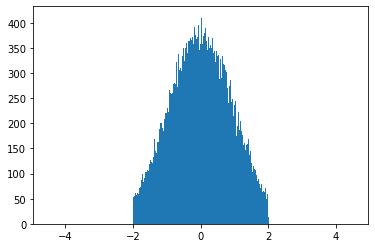

In [11]:
with tf.Session() as sess:
    a = sess.run(A)
    plt.hist(a, 1000, (-4.5, 4.5))

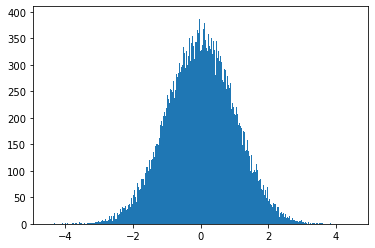

In [12]:
with tf.Session() as sess:
    b = sess.run(B)
    plt.hist(b, 1000, (-4.5, 4.5))

In [13]:
# 파라미터의 가중치, 바이어스의 초기값을 설정한다.
# CNN 모델을 구성하기 위해 많은 수의 가중치와 바이어스을 사용하게 되는데 대칭성을 깨뜨리고 기울기가 0이 되는 것을 방지하기
# 위해서 가중치에 약간의 잡음을 주어 초기화 한다.

# tf.truncated_normal()와 tf.random_normal()는 매우 비슷하게 작동하지만 큰 차이가 있다.  
# 두 함수 모두 랜덤하게 값을 가져오데 두 방식의 가장 큰 차이는 truncated_normal()은 너무 작거나 너무 큰 값이 아닌 값으로
# 랜덤한 값을 가져온다.
# 딥러닝이나 머신러닝 중 너무 큰 값(기울기 폭주)이나 너무 작은 값(기울기 소멸)이 들어오면 작동을 멈춰버리는 것을 해결하기
# 위한 방법이다.

# 가중치를 만들어 리턴하는 함수
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) # stddev 속성으로 난수가 발생되는 범위를 제한한다.
    return tf.Variable(initial)

# 바이어스를 만들어 리턴하는 함수
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [14]:
with tf.Session() as sess:
    w = weight_variable([2, 1])
    b = bias_variable([2])
    sess.run(tf.global_variables_initializer())
    print(sess.run(w), sess.run(b))

[[0.15489016]
 [0.13743858]] [0.1 0.1]


In [15]:
# https://bcho.tistory.com/tag/stride 참조
# tf.nn.conv2d(필터를 적용할 이미지 데이터, 필터, strides, padding) 함수로 이미지 데이터에 필터를 적용한다.
# strides: 필터를 움직이는 간격으로 1번째 인수와 4번째 인수는 통상적으로 1을 쓰고 2번째 인수는 가로 스트라이드 값, 3번째
#          인수는 세로 스트라이드 값을 입력한다.
# padding: 입력 데이터 행렬 주위를 무의미한 값(0)으로 감싸서 필터를 거치고 나온 피처 맵의 크기가 작아지는 것을 방지하고
#          과대적합이 발생하는 것을 방지할 수 있다.
#          SAME: 텐서플로우가 자동으로 패딩을 적용해 입력값과 출력값의 크기를 같게한다.
#          VALID: 텐서플로우가 자동으로 패딩을 적용하지 않아 입력값보다 출력값의 크기가 작아진다.

def conv2d(x, W_conv):
    return tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1,], padding='SAME')

# tf.nn.max_pool(활성화 함수로 ReLu를 적용하고 맥스 풀링을 적용할 데이터, ksize, strides, padding) 함수로 맥스 풀링을 적용한다.
# ksize: 맥스 풀링의 필터 크기로 [1, 2, 2, 1]는 2 * 2 크기로 묶어서 맥스 풀링을 한다는 의미이다.
# strides, padding는 conv2d()의 strides, padding와 의미가 같다.
# ksize, strides는 모두 필터 크기이므로 동일하게 지정해야 한다.

def max_pool_2x2(h_conv):
    return tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [16]:
# 1번째 컨볼루션 레이어는 16개의 필터를 가지고 있고 필터 크기는 5 * 5이고 바이어스는 필터의 개수만큼 만든다.
W_conv1 = weight_variable([5, 5, 1, 16]) # 1번째 컨볼루션 레이어 필터 정의
b_conv1 = bias_variable([16]) # 1번째 바이어스

# 활성화 함수로 ReLu를 사용한다.
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)

# 1번째 컨볼루션 레이어 다음으로 풀링 레이어를 적용해서 액티베이션 맵의 크기를 줄여준다.
# 액티베이션 맵의 크기를 줄여줌으로써 파라미터가 줄어들어 모델의 크기가 작아지고, 과대적합의 위험도 감소시켜 준다.
h_pool1 = max_pool_2x2(h_conv1)
# 풀링 레이어에 의해 액티베이션 맵의 크기는 14 * 14가 되었고 이 값은 다음에 이어지는 2번째 컨볼루션 레이어의 입력으로
# 들어간다.

In [17]:
# 2번째 컨볼루션 레이어는 32개의 필터를 가진다.
W_conv2 = weight_variable([5, 5, 16, 32]) # 2번째 컨볼루션 레이어 필터 정의
b_conv2 = bias_variable([32]) # 2번째 바이어스
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# 풀링 레이어에 의해 액티베이션 맵의 크기는 7 * 7이 된다.

FC(Fully Connected Layer)

In [18]:
# FC는 컨볼루션 레이어를 통해 추출된 이미지의 특징을 입력받아 0부터 9까지의 숫자 중 하나로 이미지를 분류한다.
W_fc1 = weight_variable([7 * 7 * 32, 128])
b_fc1 = bias_variable([128])

# 2번째 컨볼루션 레이어의 맥스 풀링 결과를 행과 열을 변경해서 가중치와 행렬의 곱을 이용해 계산하고 활성화 함수로 ReLu를
# 사용한다.
# shape에 -1을 입력하면 고정된 차원은 우선 채우고 남는 부분은 알하서 채워준다.
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# FC 영역에는 FC1, FC2 총 2개의 히든 레이어가 존재하고 FC1은 128개의 노드, FC2 10개의 노드가 존재한다.
# FC2에 10개의 노드가 존재하는 이유유는 FC2의 10개의 노드의 값들을 소프트맥스에 입력시켜서 각 노드별 확률을 구하기 위해서이다.
# 각 노드는 숫자 0부터 9를 의미하며, 이 예측값은 크로스 엔트로피를 통해 실제값과의 차이를 계산하는데 사용한다.
W_fc2 = weight_variable([128, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

비용 함수 정의

In [19]:
# 모델 정의가 끝났으므로 모델을 학습시키기 위해서 비용 함수를 정의한다. 비용 함수는 크로스 엔트로피를 사용한다.
# 실제값과 예측값의 크로스 엔트로피를 설정한다.
cross_entroty = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y))
# Adam 옵티마이저를 사용해 모델을 최적화한다.
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entroty)

정확도 계산

In [20]:
predict = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))

학습시킨다.

In [21]:
# 미니 배치를 사용하여 모델을 최적화한다. 미니 배치는 총 500개의 학습 데이터가 들어있고, 미니 배치마다 파라미터가 조정된다.
init = tf.global_variables_initializer() # 변수 초기화
# 하이퍼 파리미터 설정
epoch_cnt = 3
batch_size = 500
iterration = len(x_train) // batch_size

# 학습 시작
with tf.Session() as sess:
    tf.set_random_seed(35)
    sess.run(init)
    
    for epoch in range(epoch_cnt):
        avg_loss = 0.0
        start = 0
        end = batch_size
        
        for i in range(iterration):
            if i % 10 == 0:
                train_acc = accuracy.eval(feed_dict={x: x_train[start:end], y: y_train[start:end]})
                print('step: {:3d}, 학습 정확도: {:6.4f}'.format(i, train_acc))
            # ===== if
            # Adam 옵티마이저를 사용한 최적화 함수를 실행한다.
            train_step.run(feed_dict={x: x_train[start:end], y: y_train[start:end]})
            start += batch_size
            end += batch_size
        # =====
        
        # 검증 데이터로 모델을 검증한다.
        val_accuracy = accuracy.eval(feed_dict={x: x_val, y: y_val})
        print('검증 정확도: {:6.4f}'.format(val_accuracy))
    # =====
    
    # 모델을 테스트 데이터로 테스트한 정확도를 계산해서 출력한다.
    test_accuracy = accuracy.eval(feed_dict={x: x_test, y: y_test})
    print('테스트 정확도: {:6.4f}'.format(test_accuracy))

step:   0, 학습 정확도: 0.0980
step:  10, 학습 정확도: 0.5460
step:  20, 학습 정확도: 0.8100
step:  30, 학습 정확도: 0.8400
step:  40, 학습 정확도: 0.8820
step:  50, 학습 정확도: 0.9040
step:  60, 학습 정확도: 0.9140
step:  70, 학습 정확도: 0.9380
step:  80, 학습 정확도: 0.9440
step:  90, 학습 정확도: 0.9300
검증 정확도: 0.9478
step:   0, 학습 정확도: 0.9420
step:  10, 학습 정확도: 0.9560
step:  20, 학습 정확도: 0.9520
step:  30, 학습 정확도: 0.9580
step:  40, 학습 정확도: 0.9620
step:  50, 학습 정확도: 0.9600
step:  60, 학습 정확도: 0.9660
step:  70, 학습 정확도: 0.9620
step:  80, 학습 정확도: 0.9680
step:  90, 학습 정확도: 0.9640
검증 정확도: 0.9662
step:   0, 학습 정확도: 0.9620
step:  10, 학습 정확도: 0.9780
step:  20, 학습 정확도: 0.9520
step:  30, 학습 정확도: 0.9680
step:  40, 학습 정확도: 0.9700
step:  50, 학습 정확도: 0.9760
step:  60, 학습 정확도: 0.9760
step:  70, 학습 정확도: 0.9780
step:  80, 학습 정확도: 0.9820
step:  90, 학습 정확도: 0.9720
검증 정확도: 0.9759
테스트 정확도: 0.9772
